# WHAM, step by step (with plots)

This notebook is a standalone, **conceptual + hands-on** walkthrough of the **Weighted Histogram Analysis Method (WHAM)**.

**You will learn:**
1. What the *unbiased* PMF is, and how it relates to probability.
2. What an umbrella bias does to the sampled distribution.
3. How WHAM combines many biased histograms into one optimal estimate of $P(x)$.
4. How overlap between windows controls whether WHAM succeeds.

We use a 1D toy model so everything is easy to visualize.

## 1) The PMF and probability

Let $x$ be a reaction coordinate (collective variable). The **potential of mean force (PMF)** is defined from the equilibrium probability density $P(x)$:

$$F(x) = -k_BT\ln P(x) + C.$$

For a *true* 1D system with potential energy $U(x)$ at temperature $T$,

$$P(x) \propto e^{-\beta U(x)}\quad (\beta = 1/(k_BT)),$$

so the PMF differs from $U(x)$ only by an additive constant.

In real molecular systems (many hidden degrees of freedom), $F(x)$ is a free energy, not just the potential energy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

k_B = 1.0
T = 1.0
beta = 1.0 / (k_B * T)

plt.rcParams['figure.dpi'] = 120


# Beginner-friendly runtime switch
FAST_MODE = True
print(f"FAST_MODE = {FAST_MODE} (set to False for higher-statistics runs)")


## 2) Define a toy system: a double-well

We choose a symmetric double-well potential:

$$U(x) = a\,(x^2-1)^2.$$

This has two minima near $x=\pm 1$ separated by a barrier near $x=0$.

/tmp/ipython-input-1115161054.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_true = p_true_unnorm / np.trapz(p_true_unnorm, x_grid)


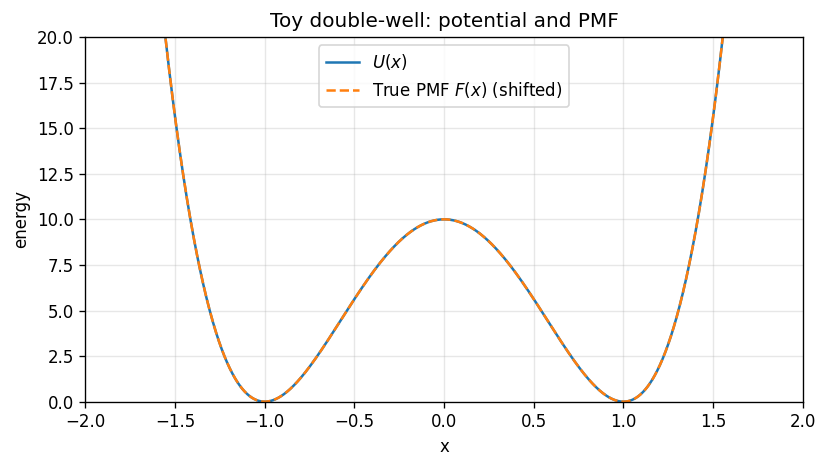

In [ ]:
a = 10.0

def U(x):
    return a * (x**2 - 1.0) ** 2

# Discretize x for plotting + for binned WHAM later
x_min, x_max = -2.2, 2.2
n_grid = 1201 if FAST_MODE else 2001
x_grid = np.linspace(x_min, x_max, n_grid)
dx = x_grid[1] - x_grid[0]

# True (unbiased) distribution on the grid and the corresponding PMF
p_true_unnorm = np.exp(-beta * U(x_grid))
P_true = p_true_unnorm / np.trapz(p_true_unnorm, x_grid)
F_true = - (1.0/beta) * np.log(P_true)
F_true -= np.min(F_true)

plt.figure(figsize=(7, 4))
plt.plot(x_grid, U(x_grid), label=r'$U(x)$')
plt.plot(x_grid, F_true, '--', label=r'True PMF $F(x)$ (shifted)')
plt.xlabel('x')
plt.ylabel('energy')
plt.ylim(0,20)
plt.xlim(-2, 2)
plt.title('Toy double-well: potential and PMF')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 3) Umbrella sampling biases

Umbrella window $i$ adds a harmonic bias centered at $x_{0,i}$:

$$w_i(x) = \tfrac{1}{2}k(x-x_{0,i})^2.$$

That window samples the **biased** distribution

$$P_i(x) \propto e^{-\beta[U(x)+w_i(x)]}.$$

A key WHAM assumption is that windows have **overlap** in $x$ so the method can stitch them together.

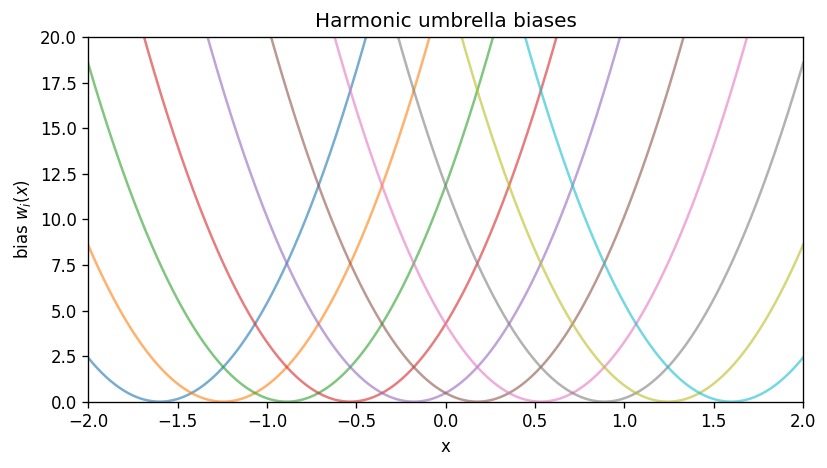

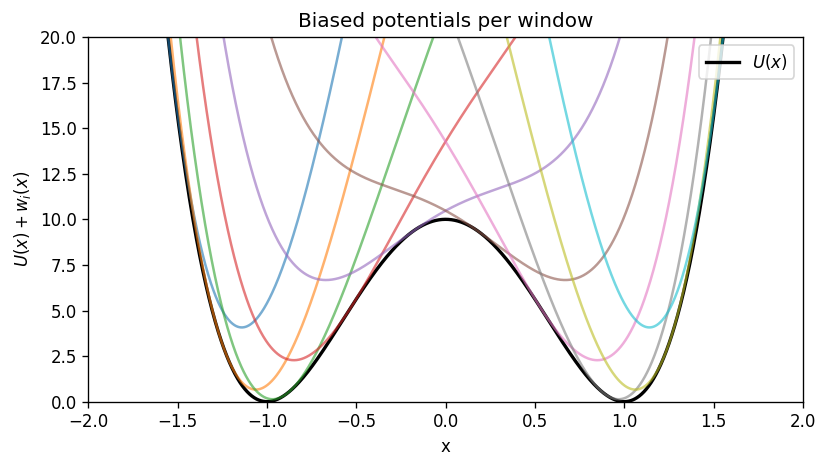

In [ ]:
# Umbrella parameters
num_windows = 10
k_umb = 30.0
centers = np.linspace(-1.6, 1.6, num_windows)

def w_i(x, x0):
    return 0.5 * k_umb * (x - x0) ** 2

# Plot the biases and biased potentials
plt.figure(figsize=(7, 4))
for x0 in centers:
    plt.plot(x_grid, w_i(x_grid, x0), alpha=0.6)
plt.xlabel('x')
plt.ylabel(r'bias $w_i(x)$')
plt.title('Harmonic umbrella biases')
plt.ylim(0,20)
plt.xlim(-2, 2)
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(x_grid, U(x_grid), color='k', lw=2, label=r'$U(x)$')
for x0 in centers:
    plt.plot(x_grid, U(x_grid) + w_i(x_grid, x0), alpha=0.6)
plt.xlabel('x')
plt.ylabel(r'$U(x)+w_i(x)$')
plt.title('Biased potentials per window')
plt.ylim(0,20)
plt.xlim(-2, 2)
# plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Interactive sliders: see WHAM work in real time

Use these sliders to change umbrella setup and immediately see:
- the biased histograms (overlap),
- the overlap heatmap,
- the reconstructed PMF vs the true PMF,
- the WHAM convergence trace,
- and which window contributes where.

If widgets do not render, you likely need `ipywidgets` enabled in your Jupyter environment.

In [ ]:
# Interactive WHAM playground (requires ipywidgets)

try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception as e:
    widgets = None
    print("ipywidgets is not available in this environment.")
    print("Error:", e)


def _expected_counts_from_bin_mass(p_mass, n_samples):
    # Deterministic integer counts with exact total n_samples.
    p_mass = np.asarray(p_mass, dtype=float)
    p_mass = p_mass / np.sum(p_mass)
    raw = p_mass * n_samples
    base = np.floor(raw).astype(int)
    remainder = int(n_samples - np.sum(base))
    if remainder > 0:
        frac = raw - base
        add_idx = np.argsort(frac)[-remainder:]
        base[add_idx] += 1
    return base


def wham_playground(
    k_umb=30.0,
    num_windows=9,
    center_range=1.6,
    n_bins=120,
    n_per_window=20000,
):
    # Grids/bins
    bin_edges = np.linspace(x_min, x_max, int(n_bins) + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]

    centers = np.linspace(-float(center_range), float(center_range), int(num_windows))

    def w_local(x, x0):
        return 0.5 * float(k_umb) * (x - x0) ** 2

    # True PMF on bin centers
    P_true_centers = np.interp(bin_centers, x_grid, P_true)
    P_true_centers = P_true_centers / (np.sum(P_true_centers) * bin_width)
    F_true_centers = -(1.0 / beta) * np.log(P_true_centers)
    F_true_centers -= np.min(F_true_centers)

    # Compute biased densities on the fine grid, then integrate into bin masses
    bin_index = np.clip(np.digitize(x_grid, bin_edges) - 1, 0, len(bin_centers) - 1)

    N_ij = np.zeros((len(centers), len(bin_centers)), dtype=int)
    u_ij = np.zeros((len(centers), len(bin_centers)), dtype=float)

    # For plots (downsample windows if too many)
    max_plot_windows = 12
    plot_ids = np.linspace(0, len(centers) - 1, min(len(centers), max_plot_windows), dtype=int)

    for i, x0 in enumerate(centers):
        # reduced bias on bin centers
        u_ij[i] = beta * w_local(bin_centers, x0)

        # biased density on x_grid
        p = np.exp(-beta * (U(x_grid) + w_local(x_grid, x0)))
        p = p / np.trapz(p, x_grid)

        # integrate p(x) over each bin to get probability mass
        p_mass = np.zeros(len(bin_centers))
        for j in range(len(bin_centers)):
            mask = bin_index == j
            p_mass[j] = np.sum(p[mask]) * dx
        p_mass = p_mass / np.sum(p_mass)

        N_ij[i] = _expected_counts_from_bin_mass(p_mass, int(n_per_window))

    n_i = np.sum(N_ij, axis=1)

    # Run WHAM using the solver defined later in the notebook if present.
    # If not, use a local minimal version.
    if 'run_wham' in globals():
        P_wham, f_wham, delta_hist = run_wham(N_ij, n_i, u_ij, max_iter=10000, tol=1e-10)
    else:
        import warnings
        def _run_wham_local(N_ij, n_i, u_ij, max_iter=20000, tol=1e-8):
            f_i = np.zeros(len(n_i))
            P_j = np.sum(N_ij, axis=0).astype(float)
            P_j /= np.sum(P_j)
            delta = []
            for _ in range(max_iter):
                f_old = f_i.copy()
                denom = np.sum(n_i[:, None] * np.exp(f_i[:, None] - u_ij), axis=0)
                numer = np.sum(N_ij, axis=0)
                P_new = numer / np.maximum(denom, 1e-300)
                P_new /= np.sum(P_new)
                P_j = P_new
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', category=RuntimeWarning)
                    Z_i = np.sum(P_j[None, :] * np.exp(-u_ij), axis=1)
                    f_i = -np.log(Z_i)
                f_i -= f_i[0]
                d = float(np.max(np.abs(f_i - f_old)))
                delta.append(d)
                if d < tol:
                    break
            return P_j, f_i, np.array(delta)
        P_wham, f_wham, delta_hist = _run_wham_local(N_ij, n_i, u_ij)

    # PMF from WHAM (P_wham is probability mass per bin)
    F_wham = -(1.0 / beta) * np.log(np.maximum(P_wham, 1e-300))
    F_wham -= np.min(F_wham)

    rmse = float(np.sqrt(np.mean((F_wham - F_true_centers) ** 2)))

    # Overlap matrix (Bhattacharyya coefficient) from histogram masses
    p_ij = N_ij / np.sum(N_ij, axis=1, keepdims=True)
    BC = np.sqrt(p_ij[:, None, :] * p_ij[None, :, :]).sum(axis=2)

    # Stitching view: window contribution fractions c_ij
    weights = n_i[:, None] * np.exp(f_wham[:, None] - u_ij)
    Cij = weights / np.sum(weights, axis=0, keepdims=True)

    # --- Plots ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))

    ax = axes[0, 0]
    ax.plot(x_grid, U(x_grid), color='k', lw=2, label=r'$U(x)$')
    ax.plot(bin_centers, F_true_centers, 'k--', lw=2, label='true PMF (binned)')
    ax.set_title('True potential & PMF')
    ax.set_xlabel('x')
    ax.set_ylabel('energy')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

    ax = axes[0, 1]
    ax.plot(bin_centers, F_true_centers, 'k--', lw=2, label='true')
    ax.plot(bin_centers, F_wham, lw=2, label=f'WHAM (RMSE={rmse:.3f})')
    ax.set_title('PMF reconstruction')
    ax.set_xlabel('x')
    ax.set_ylabel('PMF (shifted)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

    ax = axes[1, 0]
    for i in plot_ids:
        dens = N_ij[i] / (n_i[i] * bin_width)
        ax.plot(bin_centers, dens, alpha=0.7)
    ax.set_title('Biased histograms (subset)')
    ax.set_xlabel('x')
    ax.set_ylabel('density')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    ax.semilogy(delta_hist)
    ax.set_title('WHAM convergence')
    ax.set_xlabel('iteration')
    ax.set_ylabel(r'max $|\Delta f_i|$')
    ax.grid(True, which='both', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Heatmaps in a second figure
    fig2, axes2 = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes2[0]
    im = ax.imshow(BC, origin='lower', vmin=0, vmax=1, cmap='viridis')
    fig2.colorbar(im, ax=ax, label='Bhattacharyya overlap')
    ax.set_title('Window overlap')
    ax.set_xlabel('window')
    ax.set_ylabel('window')

    ax = axes2[1]
    im2 = ax.imshow(Cij, aspect='auto', origin='lower',
                    extent=[bin_centers[0], bin_centers[-1], 0, len(centers)-1],
                    cmap='magma')
    fig2.colorbar(im2, ax=ax, label='contribution $c_{ij}$')
    ax.set_title('WHAM stitching view')
    ax.set_xlabel('x')
    ax.set_ylabel('window')

    plt.tight_layout()
    plt.show()


ENABLE_WIDGET_PLAYGROUND = False  # set True when using this notebook interactively in Jupyter

if widgets is not None and ENABLE_WIDGET_PLAYGROUND:
    ui = widgets.VBox([
        widgets.FloatSlider(value=30.0, min=1.0, max=120.0, step=1.0, description='k_umb'),
        widgets.IntSlider(value=9, min=3, max=25, step=2, description='num_windows'),
        widgets.FloatSlider(value=1.6, min=0.6, max=2.2, step=0.1, description='center_range'),
        widgets.IntSlider(value=120, min=50, max=220, step=10, description='n_bins'),
        widgets.IntSlider(value=6000, min=2000, max=30000, step=1000, description='n/window'),
    ])

    out = widgets.interactive_output(
        wham_playground,
        {
            'k_umb': ui.children[0],
            'num_windows': ui.children[1],
            'center_range': ui.children[2],
            'n_bins': ui.children[3],
            'n_per_window': ui.children[4],
        },
    )

    display(ui, out)
else:
    print('Interactive widget playground skipped in batch execution. Set ENABLE_WIDGET_PLAYGROUND=True to enable it.')


## 4) What the biased PMFs look like

Each window has its own PMF (up to an additive constant) computed from the biased probability $P_i(x)$:

$$F_i(x) = -k_BT\ln P_i(x) + C_i.$$

In this 1D example, $F_i(x)$ follows $U(x)+w_i(x)$ (again, up to a constant).

/tmp/ipython-input-3465796573.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p /= np.trapz(p, x_grid)


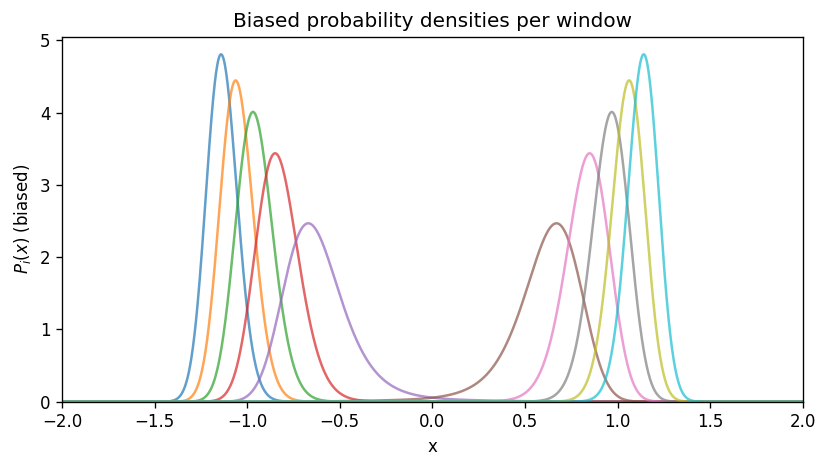

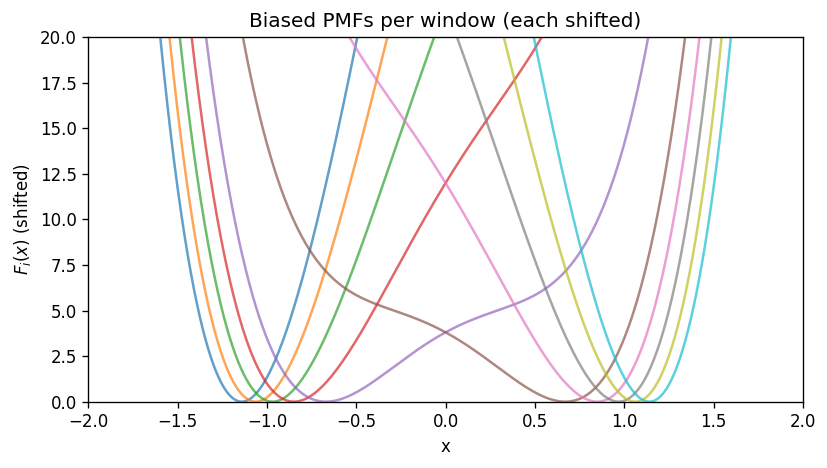

In [ ]:
# Compute biased distributions exactly on the grid
P_biased = []
for x0 in centers:
    p = np.exp(-beta * (U(x_grid) + w_i(x_grid, x0)))
    p /= np.trapz(p, x_grid)
    P_biased.append(p)
P_biased = np.array(P_biased)  # (n_win, n_grid)

plt.figure(figsize=(7, 4))
for i, x0 in enumerate(centers):
    plt.plot(x_grid, P_biased[i], label=f'i={i}, x0={x0:.2f}', alpha=0.7)
plt.xlabel('x')
plt.ylabel(r'$P_i(x)$ (biased)')
plt.title('Biased probability densities per window')
plt.xlim(-2, 2)
plt.ylim(bottom=0)
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Biased PMFs (shift each to its own minimum for visualization)
plt.figure(figsize=(7, 4))
for i, x0 in enumerate(centers):
    Fi = - (1.0/beta) * np.log(P_biased[i])
    Fi -= np.min(Fi)
    plt.plot(x_grid, Fi, alpha=0.7)
plt.xlabel('x')
plt.ylabel(r'$F_i(x)$ (shifted)')
plt.ylim(0,20)
plt.xlim(-2, 2)
plt.title('Biased PMFs per window (each shifted)')
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5) Create synthetic umbrella data (samples)

To keep the focus on WHAM (not dynamics), we generate *independent samples* from each biased distribution $P_i(x)$.

We will:
- choose WHAM bins,
- draw $n_i$ samples per window,
- build the histogram counts $N_{ij}$.

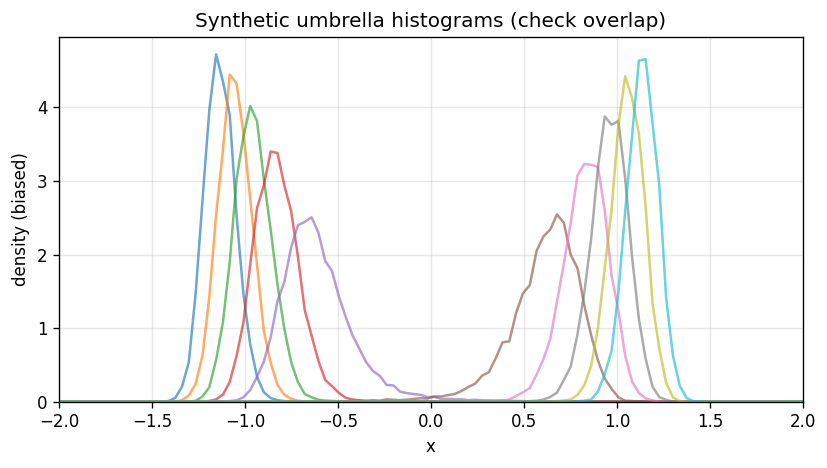

In [ ]:
# WHAM binning
n_bins = 120
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Sample counts per window
n_per_window = 5000 if FAST_MODE else 20000

# Precompute biased probability mass per bin for sampling
# (integrate P_i(x) over each bin approximately via the grid)

bin_index = np.clip(np.digitize(x_grid, bin_edges) - 1, 0, n_bins - 1)

Pmass = np.zeros((num_windows, n_bins))
for i in range(num_windows):
    for j in range(n_bins):
        mask = bin_index == j
        Pmass[i, j] = np.sum(P_biased[i, mask]) * dx
    Pmass[i] /= np.sum(Pmass[i])

# Draw samples by first choosing a bin then uniformly within the bin
samples = []
for i in range(num_windows):
    chosen_bins = rng.choice(n_bins, size=n_per_window, p=Pmass[i])
    x_lo = bin_edges[chosen_bins]
    x_hi = bin_edges[chosen_bins + 1]
    x_samp = x_lo + rng.random(n_per_window) * (x_hi - x_lo)
    samples.append(x_samp)

n_i = np.array([len(s) for s in samples], dtype=int)

# Histogram counts N_ij
N_ij = np.zeros((num_windows, n_bins), dtype=int)
for i in range(num_windows):
    N_ij[i], _ = np.histogram(samples[i], bins=bin_edges)

# Plot window histograms (densities)
bin_width = bin_edges[1] - bin_edges[0]
plt.figure(figsize=(7, 4))
for i in range(num_windows):
    dens = N_ij[i] / (n_i[i] * bin_width)
    plt.plot(bin_centers, dens, alpha=0.65)
plt.xlabel('x')
plt.ylabel('density (biased)')
plt.xlim(-2,2)
plt.ylim(bottom=0)
plt.title('Synthetic umbrella histograms (check overlap)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Overlap diagnostic (Bhattacharyya coefficient)

A compact overlap metric between window histograms is

$$\mathrm{BC}(i,k)=\sum_j \sqrt{p_{ij}p_{kj}},$$

where $p_{ij}$ is the histogram *probability mass* in bin $j$ for window $i$.

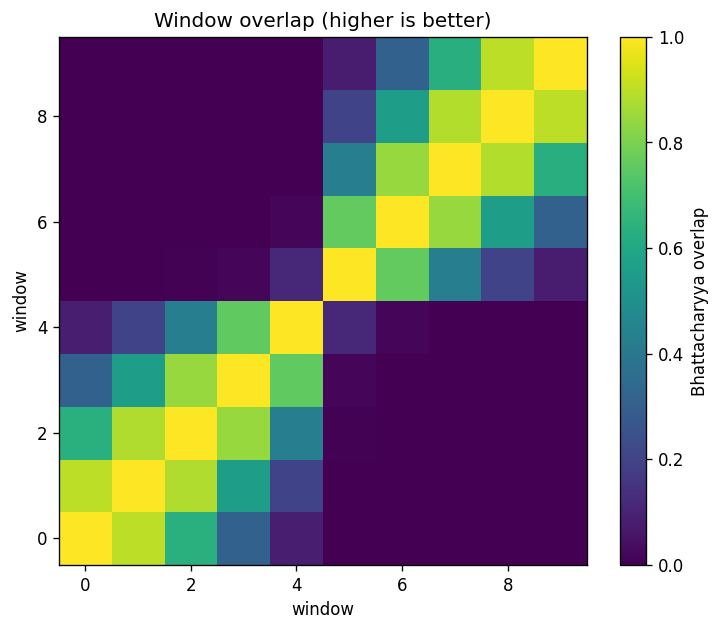

Nearest-neighbor overlap: min=0.117, median=0.846, max=0.900


In [ ]:
p_ij = np.zeros_like(N_ij, dtype=float)
for i in range(num_windows):
    if n_i[i] > 0:
        p_ij[i] = N_ij[i] / np.sum(N_ij[i])

BC = np.zeros((num_windows, num_windows), dtype=float)
for i in range(num_windows):
    for k in range(num_windows):
        if np.sum(p_ij[i]) > 0 and np.sum(p_ij[k]) > 0:
            BC[i, k] = np.sum(np.sqrt(p_ij[i] * p_ij[k]))

plt.figure(figsize=(6.2, 5.2))
plt.imshow(BC, origin='lower', vmin=0, vmax=1, cmap='viridis')
plt.colorbar(label='Bhattacharyya overlap')
plt.title('Window overlap (higher is better)')
plt.xlabel('window')
plt.ylabel('window')
plt.tight_layout()
plt.show()

if num_windows >= 2:
    nn = [BC[i, i+1] for i in range(num_windows-1)]
    print(f"Nearest-neighbor overlap: min={min(nn):.3f}, median={np.median(nn):.3f}, max={max(nn):.3f}")


## 6) The WHAM equations (written clearly)

WHAM is easiest to understand if we separate three ideas:

1. **What each window samples** (biased ensemble)
2. **What we want** (the unbiased $P(x)$ or PMF)
3. **How WHAM combines windows optimally** (self-consistent normalization)

### Biased vs. unbiased probability
Unbiased equilibrium probability density:

$$P(x)=\frac{e^{-\beta U(x)}}{Z}, \qquad Z=\int dx\,e^{-\beta U(x)}.$$

Umbrella window $i$ adds bias $w_i(x)$, so the biased density is

$$P_i(x)=\frac{e^{-\beta[U(x)+w_i(x)]}}{Z_i}, \qquad Z_i=\int dx\,e^{-\beta[U(x)+w_i(x)]}.$$

### Discretize into histogram bins
We bin $x$ into bins $j=1,\dots,N_{\mathrm{bins}}$ with centers $x_j$ and width $\Delta x$.
From window $i$ we measure histogram counts $N_{ij}$ and total samples $n_i=\sum_j N_{ij}$.

Define the **reduced bias** in bin $j$:

$$u_{ij} \equiv \beta w_i(x_j).$$

We estimate the **unbiased probability mass per bin**

$$P_j \approx \int_{\text{bin }j} dx\,P(x), \qquad \sum_j P_j = 1.$$

(If you want a *density*, use $p(x_j)\approx P_j/\Delta x$.)

### The WHAM self-consistent equations (binned form)
WHAM solves for $\{P_j\}$ and per-window constants $\{f_i\}$ (in units of $k_B T$).

The coupled equations are:

$$\boxed{\;P_j = \frac{\sum_i N_{ij}}{\sum_i n_i\exp\!\left(f_i-u_{ij}\right)}\;}$$

and

$$\boxed{\;e^{-f_i}=\sum_j P_j e^{-u_{ij}}\;}$$

Notes:
- The numerator $\sum_i N_{ij}$ is the total counts in bin $j$ across windows.
- The denominator reweights those counts by the window bias at $x_j$.
- $f_i$ is defined up to an additive constant; we set $f_0=0$.

### PMF from WHAM
Once $P_j$ is known, the reconstructed PMF is

$$F(x_j)=-k_B T\ln P_j + C,$$

where $C$ is arbitrary (we shift the minimum to 0 for plotting).

In [ ]:
import warnings

def run_wham(N_ij, n_i, u_ij, max_iter=20000, tol=1e-8):
    '''Return (P_j, f_i, delta_f_hist).'''
    N_ij = np.asarray(N_ij)
    n_i = np.asarray(n_i)
    u_ij = np.asarray(u_ij)

    n_win, n_bins = N_ij.shape

    # init
    f_i = np.zeros(n_win)
    P_j = np.sum(N_ij, axis=0).astype(float)
    if np.sum(P_j) <= 0:
        raise ValueError('No counts in any bin.')
    P_j /= np.sum(P_j)

    delta_hist = []

    for it in range(max_iter):
        f_old = f_i.copy()

        # Update P_j
        denom = np.sum(n_i[:, None] * np.exp(f_i[:, None] - u_ij), axis=0)
        numer = np.sum(N_ij, axis=0)

        P_new = np.zeros_like(P_j)
        ok = denom > 1e-300
        P_new[ok] = numer[ok] / denom[ok]

        s = np.sum(P_new)
        if s <= 0:
            raise RuntimeError('WHAM collapsed: sum(P_new) <= 0 (likely zero overlap).')
        P_j = P_new / s

        # Update f_i
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=RuntimeWarning)
            Z_i = np.sum(P_j[None, :] * np.exp(-u_ij), axis=1)
            f_i = -np.log(Z_i)

        f_i -= f_i[0]

        delta = float(np.max(np.abs(f_i - f_old)))
        delta_hist.append(delta)
        if delta < tol:
            break

    return P_j, f_i, np.array(delta_hist)

# Reduced bias energies u_ij = beta*w_i(x_j)
u_ij = np.zeros((num_windows, n_bins))
for i, x0 in enumerate(centers):
    u_ij[i] = beta * w_i(bin_centers, x0)

P_wham, f_wham, delta_hist = run_wham(N_ij, n_i, u_ij, max_iter=5000, tol=1e-10)
print('WHAM iterations:', len(delta_hist))
print('max |Δf| final:', delta_hist[-1])


WHAM iterations: 2121
max |Δf| final: 9.957457081100074e-11


## 7) Reconstructed PMF vs the true PMF

We compare WHAM’s reconstructed PMF to the analytically computed PMF for the toy model.

Important: both PMFs are only defined up to an additive constant, so we shift them to have minimum 0.

/tmp/ipython-input-2472367974.py:2: RuntimeWarning: divide by zero encountered in log
  F_wham = - (1.0/beta) * np.log(P_wham)


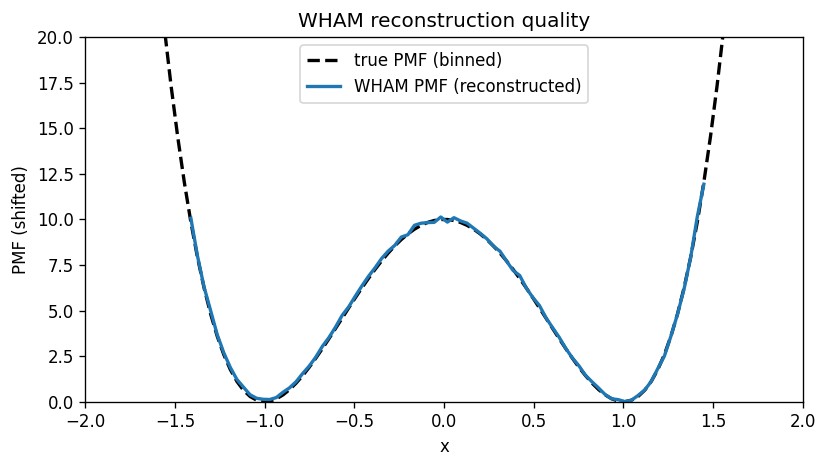

RMSE(PMF) over bins: inf (in energy units)


In [ ]:
# Convert WHAM bin probabilities to a PMF
F_wham = - (1.0/beta) * np.log(P_wham)
F_wham -= np.min(F_wham)

# True PMF evaluated at bin centers (from the exact P_true on the grid)
P_true_centers = np.interp(bin_centers, x_grid, P_true)
P_true_centers /= np.sum(P_true_centers) * (bin_edges[1] - bin_edges[0])  # renormalize as density

F_true_centers = - (1.0/beta) * np.log(P_true_centers)
F_true_centers -= np.min(F_true_centers)

plt.figure(figsize=(7, 4))
plt.plot(bin_centers, F_true_centers, 'k--', lw=2, label='true PMF (binned)')
plt.plot(bin_centers, F_wham, lw=2, label='WHAM PMF (reconstructed)')
plt.xlabel('x')
plt.ylabel('PMF (shifted)')
plt.title('WHAM reconstruction quality')
# plt.grid(True, alpha=0.3)
plt.xlim(-2,2)
plt.ylim(0,20)
plt.legend()
plt.tight_layout()
plt.show()

rmse = np.sqrt(np.mean((F_wham - F_true_centers)**2))
print(f'RMSE(PMF) over bins: {rmse:.4f} (in energy units)')


### WHAM convergence trace

We monitor convergence using $\max_i|\Delta f_i|$ per iteration.

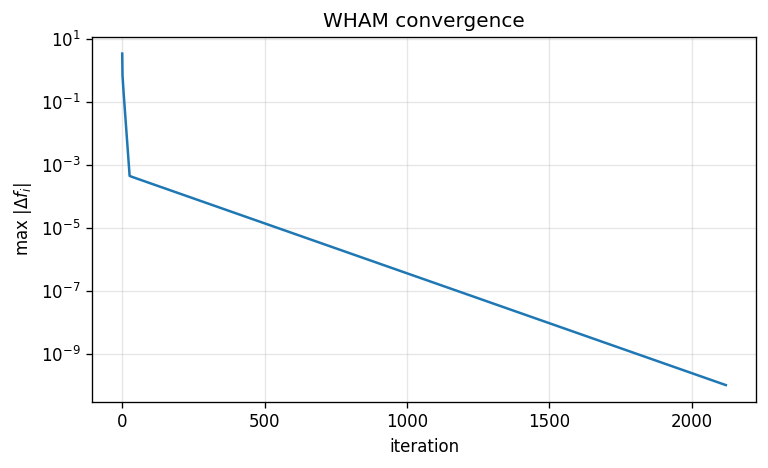

In [ ]:
plt.figure(figsize=(6.5, 4))
plt.semilogy(delta_hist)
plt.xlabel('iteration')
plt.ylabel(r'max $|\Delta f_i|$')
plt.title('WHAM convergence')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()


## 8) How WHAM stitches windows (a helpful weight view)

One way to see the stitching is to look at the *fractional contribution* of each window to each bin's denominator:

$$c_{ij}=\frac{n_i\,\exp(f_i-u_{ij})}{\sum_k n_k\,\exp(f_k-u_{kj})}.$$

For a given $x_j$, WHAM mostly trusts the windows whose umbrellas actually sample that region.

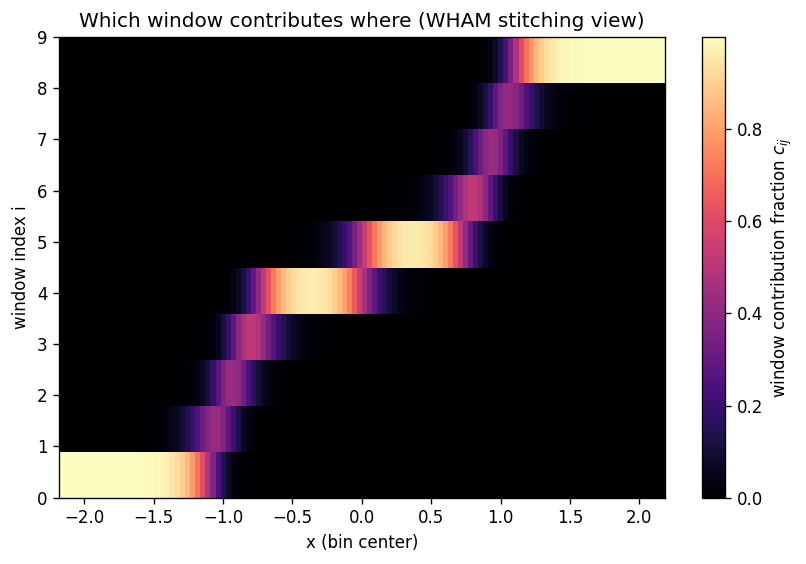

In [ ]:
weights = n_i[:, None] * np.exp(f_wham[:, None] - u_ij)
C = weights / np.sum(weights, axis=0, keepdims=True)

plt.figure(figsize=(7, 4.8))
plt.imshow(C, aspect='auto', origin='lower',
           extent=[bin_centers[0], bin_centers[-1], 0, num_windows-1],
           cmap='magma')
plt.colorbar(label='window contribution fraction $c_{ij}$')
plt.yticks(range(num_windows), [f'{i}' for i in range(num_windows)])
plt.xlabel('x (bin center)')
plt.ylabel('window index i')
plt.title('Which window contributes where (WHAM stitching view)')
plt.tight_layout()
plt.show()


## 9) Experiment: what happens if overlap is poor?

Try changing `num_windows` or `k_umb` above and re-running the notebook.

Typical failure mode:
- windows become too narrow / too far apart → little overlap → WHAM becomes noisy or unstable.

A practical workflow is:
1. plot the window histograms,
2. check the overlap matrix,
3. only then trust the WHAM PMF.